## 데이터 전처리

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data = pd.read_csv('train.csv', encoding='latin1')
data = data[['sentiment', 'text']]
data.head()

,sentiment,text
0,neutral,"I`d have responded, if I were going"
1,negative,Sooo SAD I will miss you here in San Diego!!!
2,negative,my boss is bullying me...
3,negative,what interview! leave me alone
4,negative,"Sons of ****, why couldn`t they put them on t..."


In [3]:
data = data[data.sentiment != "neutral"]

In [4]:
import re

# 함수 정의: http:// 또는 @로 시작하는 단어를 삭제
def remove_patterns(text):
    text = re.sub(r'http\S+', '', text)  # http로 시작하는 단어 삭제
    text = re.sub(r'@\S+', '', text)     # @로 시작하는 단어 삭제
    return text

In [5]:
# 소문자로 변환한 후 공백, 알파벳, 숫자 외 모두 제거
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply(remove_patterns)
data['text'] = data['text'].str.strip()

In [6]:
print(data[ data['sentiment'] == 'positive'].shape) #Positive
print(data[ data['sentiment'] == 'negative'].shape) #Negative

(8582, 2)
(7781, 2)


## 토큰화

In [7]:
# 텍스트 데이터를 토큰화
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

## LSTM 모델

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [10]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10963, 34) (10963, 2)
(5400, 34) (5400, 2)


## 모델 학습

In [13]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
686/686 - 37s - 55ms/step - accuracy: 0.9645 - loss: 0.0955
Epoch 2/10
686/686 - 36s - 53ms/step - accuracy: 0.9725 - loss: 0.0789
Epoch 3/10
686/686 - 34s - 50ms/step - accuracy: 0.9750 - loss: 0.0685
Epoch 4/10
686/686 - 38s - 56ms/step - accuracy: 0.9748 - loss: 0.0684
Epoch 5/10
686/686 - 38s - 55ms/step - accuracy: 0.9763 - loss: 0.0644
Epoch 6/10
686/686 - 44s - 65ms/step - accuracy: 0.9795 - loss: 0.0550
Epoch 7/10
686/686 - 49s - 71ms/step - accuracy: 0.9839 - loss: 0.0460
Epoch 8/10
686/686 - 43s - 62ms/step - accuracy: 0.9810 - loss: 0.0480
Epoch 9/10
686/686 - 55s - 81ms/step - accuracy: 0.9838 - loss: 0.0441
Epoch 10/10
686/686 - 45s - 66ms/step - accuracy: 0.9838 - loss: 0.0410


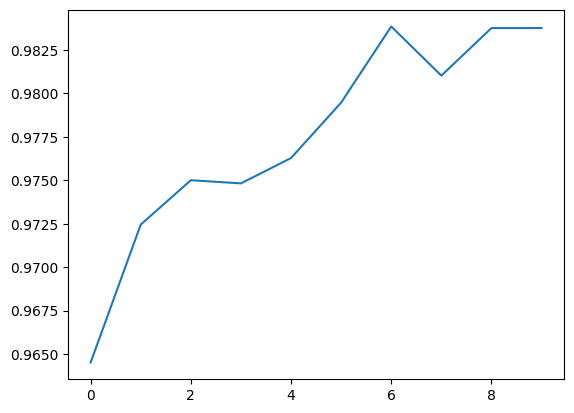

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.show()

## 정확도 확인 및 모델 검증

In [16]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

244/244 - 2s - 9ms/step - accuracy: 0.8572 - loss: 0.7358
score: 0.74
acc: 0.86


In [17]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 72ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 11ms/step
1/1 - 0s - 10ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 12ms/step
1/1 - 0s - 10ms/step
1/1 - 0s - 10ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 7ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 11ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 12ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 8ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 9ms/step
1/1 - 0s - 8

## 다른 데이터 셋으로 확인

In [18]:
test = pd.read_csv('test.csv', encoding='latin1')
test = test[['sentiment', 'text']]
test.shape

(4815, 2)

In [19]:
test = test[test.sentiment != "neutral"]
test.shape

(3385, 2)

In [20]:
def to_lower(text):
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, str):
        return text.lower()
    return text

In [21]:
test['text'] = test['text'].apply(to_lower)
test['text'] = test['text'].apply(remove_patterns)
test['text'] = test['text'].str.strip()
test.head()

,sentiment,text
1,positive,shanghai is also really exciting (precisely --...
2,negative,"recession hit veronique branquinho, she has to..."
3,positive,happy bday!
4,positive,- i like it!!
5,positive,that`s great!! weee!! visitors!


In [22]:
test = test.dropna(subset=['sentiment'])
test['sentiment'] = test['sentiment'].map({'negative': 0, 'positive': 1})

y_true = test['sentiment'].values.tolist()
test.shape

(2104, 2)

In [23]:
sentiment = []

for txt in test['text']:
    txt = tokenizer.texts_to_sequences(txt)
    txt = pad_sequences(txt, maxlen=28, dtype='int32', value=0)
    result = model.predict(txt,batch_size=1,verbose = 2)[0]

    sentiment.append(np.argmax(result))

102/102 - 0s - 3ms/step
78/78 - 0s - 2ms/step
11/11 - 0s - 3ms/step
13/13 - 0s - 2ms/step
31/31 - 0s - 2ms/step
39/39 - 0s - 2ms/step
72/72 - 0s - 2ms/step
70/70 - 0s - 2ms/step
130/130 - 0s - 2ms/step
100/100 - 0s - 2ms/step
83/83 - 0s - 2ms/step
8/8 - 0s - 3ms/step
12/12 - 0s - 2ms/step
72/72 - 0s - 2ms/step
37/37 - 0s - 2ms/step
53/53 - 0s - 2ms/step
57/57 - 0s - 2ms/step
36/36 - 0s - 2ms/step
13/13 - 0s - 2ms/step
35/35 - 0s - 2ms/step
81/81 - 0s - 2ms/step
33/33 - 0s - 2ms/step
28/28 - 0s - 2ms/step
32/32 - 0s - 2ms/step
66/66 - 0s - 2ms/step
63/63 - 0s - 2ms/step
93/93 - 0s - 2ms/step
28/28 - 0s - 2ms/step
22/22 - 0s - 2ms/step
66/66 - 0s - 2ms/step
9/9 - 0s - 3ms/step
38/38 - 0s - 2ms/step
12/12 - 0s - 2ms/step
54/54 - 0s - 2ms/step
79/79 - 0s - 2ms/step
60/60 - 0s - 2ms/step
61/61 - 0s - 2ms/step
137/137 - 0s - 2ms/step
89/89 - 0s - 2ms/step
60/60 - 0s - 2ms/step
114/114 - 0s - 2ms/step
34/34 - 0s - 2ms/step
35/35 - 0s - 2ms/step
75/75 - 0s - 2ms/step
79/79 - 0s - 2ms/step
40/4

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = sentiment

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [25]:
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 socre : {f1}")

Accuracy : 0.46387832699619774
Precision : 0.4873864783047427
Recall : 0.43789664551223934
F1 socre : 0.46131805157593125
